# Define unit cell, disretize it, use poisson disk sampling, and find area fraction all together in the same cell. Brief explanations are given in the uniform Voronoi code.

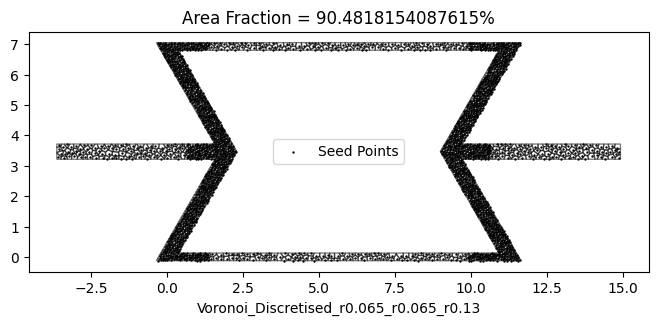

In [5]:
import numpy as np
from shapely.geometry import Point, Polygon, LineString, MultiLineString
from shapely.ops import unary_union, linemerge
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from math import pi,sin,cos,tan
from scipy.spatial import cKDTree

# This function handles Voronoi regions with infinite area
def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max() * 2   # To extend far beyond our dimensional limit

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        ridges = all_ridges.get(p1, [])
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            # Project the infinite edge outward
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = midpoint + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # Sort vertices counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# Here, we define our cell geometry's parameters
l = 4.
h = 12.
theta = 60 * pi / 180
t = 0.5
line_thickness = 0.1
h = h - (t/sin(theta)) - (t/(2*tan(theta)))

outer_coords = [(-t/(2*sin(theta)) - (t/(4*(tan(theta)))), -t/4), (h + (t/(2*sin(theta))) + (t/(4*tan(theta))), -t/4),
                (h - (l*cos(theta)) + (t/(2*sin(theta))) + (t/(2*(tan(theta)))), l*sin(theta) - (t/2)), (h - l*cos(theta) + (h/2), l*sin(theta) - (t/2)),
                (h - l*cos(theta) + (h/2), l*sin(theta) + (t/2)), (h - (l*cos(theta)) + (t/(2*sin(theta))) + (t/(2*(tan(theta)))), l*sin(theta) + (t/2)),
                (h + (t/(2*sin(theta))) + (t/(4*tan(theta))), 2*l*sin(theta) + t/4), (-t/(2*sin(theta)) - (t/(4*(tan(theta)))), 2*l*sin(theta) + t/4),
                (l*cos(theta) - (t/(2*sin(theta))) - (t/(2*tan(theta))), l*sin(theta) + (t/2)), (l*cos(theta) - (h/2), l*sin(theta) + (t/2)),
                (l*cos(theta) - (h/2), l*sin(theta) - (t/2)), (l*cos(theta) - (t/(2*sin(theta))) - (t/(2*tan(theta))), l*sin(theta) - (t/2))
]
outer_poly = Polygon(outer_coords)


inner_coords = [((t/(2*sin(theta))) + (t/(4*tan(theta))), (t/4)), (h - (t/(2*sin(theta))) - (t/(4*tan(theta))), (t/4)),
                (h - l*cos(theta) - (t/(2*sin(theta))), l*sin(theta)), (h - (t/(2*sin(theta))) - (t/(4*tan(theta))), 2*l*sin(theta) - (t/4)),
                ((t/(2*sin(theta))) + (t/(4*tan(theta))), 2*l*sin(theta) - (t/4)), (l*cos(theta) + (t/(2*sin(theta))), l*sin(theta))
]
inner_poly = Polygon(inner_coords)

ring_poly = outer_poly.difference(inner_poly)

# use Poisson disk sampling to distribute points uniformly within the unit cell (same as the code from the uniform Voronoi generation)
def poisson_disk_sampling(domain_polygon, r, k=30):

    minx, miny, maxx, maxy = domain_polygon.bounds
    cell_size = r / np.sqrt(2)

    grid = {}
    active_list = []

    while True:
        p0 = np.array([np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)])
        if domain_polygon.contains(Point(p0)):
            active_list.append(p0)
            grid[tuple(p0)] = p0
            break

    points = [p0]

    while active_list:
        idx = np.random.randint(len(active_list))
        point = active_list[idx]

        found_new_point = False
        for _ in range(k):
            theta = np.random.uniform(0, 2 * np.pi)
            radius = np.random.uniform(r, 2 * r)
            new_point = point + radius * np.array([np.cos(theta), np.sin(theta)])

            if not domain_polygon.contains(Point(new_point)):
                continue
            if len(points) > 0:
                tree = cKDTree(points)
                distances, _ = tree.query(new_point, k=1)
                if distances < r:
                    continue

            active_list.append(new_point)
            grid[tuple(new_point)] = new_point
            points.append(new_point)
            found_new_point = True

        if not found_new_point:
            active_list.pop(idx)

    return np.array(points)

#----------------------------------------------------------------------------------------------------------------------------
# Discretise the unit cell into 12 segments to vary the density distribution manually

x_1 = l*cos(theta) - (l/3)
x0 = (-t/(2*sin(theta))) - (t/(4*(tan(theta))))
x1 = (l*cos(theta)/3) - (t/(2*sin(theta)))
x2 = (2*l*cos(theta)/3) - (t/(2*sin(theta)))
x3 = (l*cos(theta)/3) + (t/(2*sin(theta)))
x4 = (2*l*cos(theta)/3) + (t/(2*sin(theta)))
x5 = h - x4
x6 = h - x3
x7 = h - x2
x8 = h - x1
x9 = h - x0
x10 = h - x_1
xa = l*cos(theta) + (t/(2*sin(theta)))
xb = h - l*cos(theta) - (t/(2*sin(theta)))
y0 = l*sin(theta)/3
y1 = 2*l*sin(theta)/3
y2 = 4*l*sin(theta)/3
y3 = 5*l*sin(theta)/3
y4 = 2*l*sin(theta) - (t/4)
y5 = 2*l*sin(theta) + (t/4)

#bottomleft
box1 = Polygon([
    (x0, -t/4),
    (l/3, -t/4),
    (l/3, y0),
    (x0, y0)
])
A1 = ring_poly.intersection(box1)

#botton
box2 = Polygon([
    (l/3, -t/4),
    (h - (l/3), -t/4),
    (h - (l/3), t/4),
    (l/3, t/4)
])
A2 = ring_poly.intersection(box2)

#bottomright
box3 = Polygon([
    (h - (l/3), -t/4),
    (x9, -t/4),
    (x9, y0),
    (h - (l/3), y0)
])
A3 = ring_poly.intersection(box3)

#rightslantbotton
box4 = Polygon([
    (x5, y0),
    (x8, y0),
    (x8, y1),
    (x5, y1)
])
A4 = ring_poly.intersection(box4)

#right
box5 = Polygon([
    (xb, y1),
    (x10, y1),
    (x10, y2),
    (xb, y2)
])
A5 = ring_poly.intersection(box5)

#topslantright
box6 = Polygon([
    (x5, y2),
    (x8, y2),
    (x8, y3),
    (x5, y3)
])
A6 = ring_poly.intersection(box6)

#topright
box7 = Polygon([
    (h - (l/3), y3),
    (x9, y3),
    (x9, y5),
    (h - (l/3), y5)
])
A7 = ring_poly.intersection(box7)

#top
box8 = Polygon([
    (l/3, y4),
    (h - (l/3), y4),
    (h - (l/3), y5),
    (l/3, y5)
])
A8 = ring_poly.intersection(box8)

#topleft
box9 = Polygon([
    (x0, y3),
    (l/3, y3),
    (l/3, y5),
    (x0, y5)
])
A9 = ring_poly.intersection(box9)

#leftslanttop
box10 = Polygon([
    (x1, y2),
    (x4, y2),
    (x4, y3),
    (x1, y3)
])
A10 = ring_poly.intersection(box10)

#left
box11 = Polygon([
    (x_1, y1),
    (xa, y1),
    (xa, y2),
    (x_1, y2)
])
A11 = ring_poly.intersection(box11)

#leftslantbottom
box12 = Polygon([
    (x1, y0),
    (x4, y0),
    (x4, y1),
    (x1, y1)
])
A12 = ring_poly.intersection(box12)

#left_ext
box13 = Polygon([
    (l*cos(theta) - (h/2), y1),
    (x_1, y1),
    (x_1, y2),
    (l*cos(theta) - (h/2), y2)
])
A13 = ring_poly.intersection(box13)

#right_ext
box14 = Polygon([
    (x10, y1),
    (h - l*cos(theta) + (h/2), y1),
    (h - l*cos(theta) + (h/2), y2),
    (x10, y2)
])
A14 = ring_poly.intersection(box14)

r1 = 0.065
r2 = 0.065
r3 = 0.13

points_A1 = poisson_disk_sampling(A1, r1)
points_A2 = poisson_disk_sampling(A2, r3)
points_A3 = poisson_disk_sampling(A3, r1)
points_A4 = poisson_disk_sampling(A4, r2)
points_A5 = poisson_disk_sampling(A5, r1)
points_A6 = poisson_disk_sampling(A6, r2)
points_A7 = poisson_disk_sampling(A7, r1)
points_A8 = poisson_disk_sampling(A8, r3)
points_A9 = poisson_disk_sampling(A9, r1)
points_A10 = poisson_disk_sampling(A10, r2)
points_A11 = poisson_disk_sampling(A11, r1)
points_A12 = poisson_disk_sampling(A12, r2)
points_A13 = poisson_disk_sampling(A13, r3)
points_A14 = poisson_disk_sampling(A14, r3)

all_points = np.vstack([points_A1, points_A2, points_A3, points_A4, points_A5, points_A6, points_A7, points_A8, points_A9, points_A10, points_A11, points_A12, points_A13, points_A14])

vor = Voronoi(all_points)
regions, vertices = voronoi_finite_polygons_2d(vor, radius=2 * max(h, 2 * l * sin(theta)))

cells = []
for region in regions:
    poly = Polygon(vertices[region]).intersection(ring_poly)
    if not poly.is_empty:
        cells.append(poly)

#-------------------------------------------------------------------------------------------------------------------------------
# Calculate area fraction (same as the code from the uniform Voronoi generation)

n_corner_points = len(outer_coords) + len(inner_coords)
boundary_point_indices = set(range(n_corner_points))

unique_voronoi_edges = []

for ridge_idx, ridge in enumerate(vor.ridge_vertices):
    if -1 in ridge:
        continue

    p1, p2 = vor.ridge_points[ridge_idx]

    if p1 in boundary_point_indices or p2 in boundary_point_indices:
        continue

    line = LineString([vor.vertices[ridge[0]], vor.vertices[ridge[1]]])
    clipped_line = line.intersection(ring_poly)
    if not clipped_line.is_empty:
        unique_voronoi_edges.append(clipped_line)

for ridge_idx, ridge in enumerate(vor.ridge_vertices):
    if -1 not in ridge:
        continue
    p1, p2 = vor.ridge_points[ridge_idx]

    if p1 in boundary_point_indices or p2 in boundary_point_indices:
        continue

    point1 = vor.points[p1]
    point2 = vor.points[p2]
    midpoint = (point1 + point2) / 2
    direction = np.array([-point2[1] + point1[1], point2[0] - point1[0]])
    direction /= np.linalg.norm(direction)
    far_point = midpoint + direction * np.ptp(vor.points).max() * 2

    if ridge[0] == -1:
        finite_edge = LineString([far_point, vor.vertices[ridge[1]]])
    else:
        finite_edge = LineString([vor.vertices[ridge[0]], far_point])

    clipped_line = finite_edge.intersection(ring_poly)
    if not clipped_line.is_empty:
        unique_voronoi_edges.append(clipped_line)

total_voronoi_length = 0.5 * sum(edge.length for edge in unique_voronoi_edges)
voronoi_coverage = line_thickness * total_voronoi_length
total_area = ring_poly.area

title_area = "Area Fraction = " + str(voronoi_coverage*100/total_area) + "%"

fig, ax = plt.subplots(figsize=(8, 8))
for cell in cells:
    if cell.geom_type == 'Polygon':
        x, y = cell.exterior.xy
        ax.fill(x, y, facecolor = 'none', alpha=0.5, edgecolor='black')
    elif cell.geom_type == 'MultiPolygon':
        for geom in cell.geoms:
            x, y = geom.exterior.xy
            ax.fill(x, y, facecolor = 'none', alpha=0.5, edgecolor='black')

ax.scatter(all_points[:,0], all_points[:,1], color='black', s=0.5, label='Seed Points')

figname = "Voronoi_Discretised_r" + str(r1) + "_r" + str(r2) + "_r" + str(r3) + ".png"

ax.set_aspect('equal')
plt.title(title_area)
plt.legend()
plt.xlabel("Voronoi_Discretised_r" + str(r1) + "_r" + str(r2) + "_r" + str(r3))
plt.savefig(figname, dpi=1000)
plt.show()

# Export the biomimetic (non-uniform) heirarchical line geometry to a .dxf file

In [ ]:
import ezdxf

def add_polygon_to_dxf(msp, polygon, layer_name='Voronoi'):
    if polygon.is_empty:
        return

    if polygon.geom_type == 'Polygon':
        _add_single_polygon(msp, polygon, layer_name)
    elif polygon.geom_type == 'MultiPolygon':
        for poly in polygon.geoms:
            _add_single_polygon(msp, poly, layer_name)

def _add_single_polygon(msp, polygon, layer_name='Voronoi'):
    exterior_coords = list(polygon.exterior.coords)
    msp.add_polyline2d(exterior_coords, close=True, dxfattribs={'layer': layer_name})

    for interior in polygon.interiors:
        interior_coords = list(interior.coords)
        msp.add_polyline2d(interior_coords, close=True, dxfattribs={'layer': layer_name})

doc = ezdxf.new(dxfversion='R2000')
msp = doc.modelspace()

for cell in cells:
    add_polygon_to_dxf(msp, cell)

doc.saveas("voronoi_output.dxf")

doc = ezdxf.readfile("voronoi_output.dxf")
msp = doc.modelspace()

for polyline in msp.query("POLYLINE"):
    points = list(polyline.points())

    for i in range(len(points) - 1):
        start = points[i]
        end = points[(i + 1) % len(points)]
        msp.add_line((start[0], start[1]), (end[0], end[1]))

    msp.delete_entity(polyline)

doc.saveas("Voronoi_Discretised_r" + str(r1) + "_r" + str(r2) + "_r" + str(r3) + ".dxf")
print("Converted Polyline2D to Line and saved successfully.")

Converted Polyline2D to Line and saved successfully.
